In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
from typing import List, Tuple
from quadratic_program import QuadraticProgram
from solvers import InfeasibleStartNewton, FeasibleStartNewton

In [29]:
np.set_printoptions(threshold=np.inf)

## References

https://cse.lab.imtlucca.it/~bemporad/publications/papers/ijc_rtiltv.pdf

https://web.stanford.edu/~boyd/papers/pdf/fast_mpc.pdf

https://www.imtek.de/professuren/systemtheorie/events/dateien/directshootingmethods

https://www.matthewpeterkelly.com/tutorials/trajectoryOptimization/cartPoleCollocation.svg#frame1114

In [30]:
def pendulum_position(z: np.ndarray, l_pend: float):
    '''
    Returns the position of the mass at the end of a pendulum attached to a cart given some current system state.
    - z = Cartpole system state: [cart position, pendulum angle, cart speed, pendulum angular speed]
    - l_pend = Length of a pendulum
    '''
    return np.array([z[0] + l_pend * np.sin(z[1]), -l_pend * np.cos(z[1])])

In [31]:
def plot_pendulum_time_sequence(states: List, l_pend: float, keyframe_stride: int=4, filename: str=None):
    '''
    Plots the cart position, pendulum arm, and pendulum mass position for a sequence of 4d
    states indicating the system's [cart_pos, pendulum_angle, cart_speed, pendulum_angular_speed].

    Add shapes to matplotlib plot:
    https://www.scaler.com/topics/matplotlib/plot-shape-matplotlib/

    - states = List of cartpole states
    - l_pend = Length of the pendulum
    - keyframe_stride = Number of frames to skip plotting the whole cartpole system
    - filename = Name of the file to save the plot to
    '''

    positions = [pendulum_position(z, l_pend) for z in states]

    keyframe_states = [s for i, s in enumerate(states) if (i % keyframe_stride) == 0]
    keyframe_colors = cm.rainbow(np.linspace(0, 1, int(len(states) / keyframe_stride) + 1))
    colors = cm.rainbow(np.linspace(0, 1, len(states)))
    fig = plt.figure()
    ax = fig.add_subplot()
    # ax.set_ylim([-1.25 * l_pend, 1.25 * l_pend])
    for i, ks in enumerate(keyframe_states):
        cart = plt.Rectangle((ks[0] - 0.125/2, 0.0), 0.125, 0.125/2, fc=keyframe_colors[i])
        plt.plot([ks[0], ks[0] + l_pend * np.sin(ks[1])], [0.0, -l_pend * np.cos(ks[1])], color=keyframe_colors[i])
        plt.gca().add_patch(cart)
    plt.scatter([p[0] for p in positions], [p[1] for p in positions], color=colors, s=0.25)
    
    # plt.axis('equal')
    plt.ylim(-1.25 * l_pend, 1.25 * l_pend)
    plt.gca().set_aspect('equal')
    if filename is not None:
        plt.savefig(filename, dpi=8000.0, bbox_inches='tight')

    fig = plt.figure()
    plt.title("pendulum angle")
    plt.plot([z[1] for z in states])
    fig = plt.figure()
    plt.title("position")
    plt.plot([z[0] for z in states])

    plt.show()

In [32]:
def rk4(x_init: np.ndarray, t_init: float, dt: float, f):
    '''
    Integrates the dynamics of `x_dot = f(x, t)` over a time interval `dt` given an initial state, `x_init`, and time, `t_init`
    using the RK4 algorithm.
    Returns the state at the end of the time interval `dt`.

    - x_init = Initial system state
    - t_init = Initial time
    - dt = Time interval over which `f` is integrated
    - f = f(t, x) - the function representing the time derivative of the state vector, `x`
    '''
    k1 = f(t_init, x_init)
    k2 = f(t_init + dt/2, x_init + dt * k1/2)
    k3 = f(t_init + dt/2, x_init + dt * k2/2)
    k4 = f(t_init + dt, x_init + dt * k3)

    return x_init + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

In [33]:
def cartpole_dynamics(t: float, z: np.ndarray, u: float, u_max: float=1.0, m_cart: float=1.0, m_pend: float=1.0, l_pend: float=1.0):
    '''
    Returns the time derivative of the state of a cartpole system given some current time, state, and control input.

    - t = Time (ignored)
    - z = Cartpole system state, [cart_pos, pend_angle, cart_pos_speed, pend_angle_speed]
    - u = Force exerted on cart, clamped between +/-u_max
    - u_max = Maximum force exerted on the cart
    - m_cart = Mass of the cart
    - m_pend = Mass of the pendulum
    - l_pend = Length of the pendulum
    '''
    u = np.clip(u, -u_max, u_max)
    cosz1 = np.cos(z[1])
    sinz1 = np.sin(z[1])
    alpha = (m_pend + m_cart) / (m_pend * l_pend)
    g = 9.8
    denom = (cosz1 * cosz1 - alpha)

    return np.array(
        [
            z[2],
            z[3],
            (-g * sinz1 * cosz1 - l_pend * u - l_pend * (z[3]**2) * sinz1) / denom,
            (alpha * g * sinz1 + u * cosz1 + (z[3]**2 * sinz1 * cosz1)) / denom
         ]
    )

In [34]:
def cartpole_demo(z_init: np.ndarray, u_init: float, t_max: float, u_max: float=1.0):
    zs = []
    zs.append(copy.copy(z_init))
    dt = 0.01
    const_force_dynamics = lambda t, y : cartpole_dynamics(t, y, u_init, u_max)
    
    for i in range(int(t_max / dt)):
        zs.append(rk4(zs[-1], dt * i, dt, const_force_dynamics))

    pendulum_positions = [pendulum_position(z, 1.0) for z in zs]

    plot_pendulum_time_sequence(zs, 1.0)

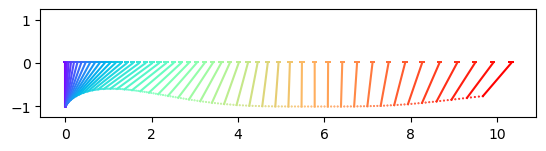

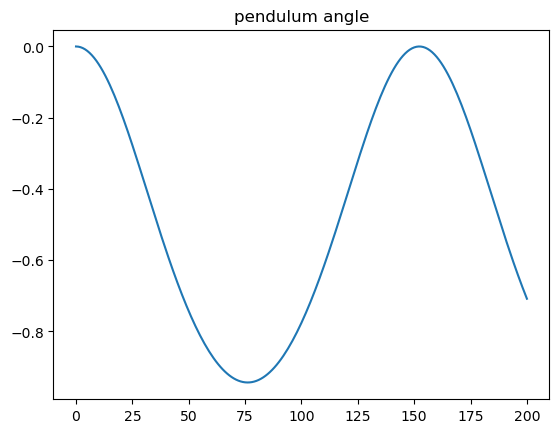

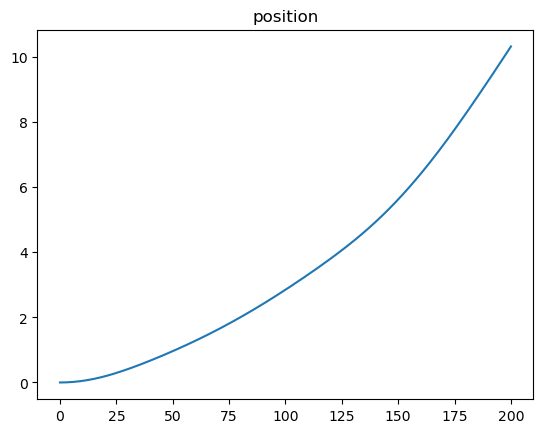

In [35]:
cartpole_demo([0.0, 0.0, 0.0, 0.0], 10.0, 2, u_max=10.0)

The dynamics of a system are governed by

$\dot{\mathbf{z}} = f(t, \mathbf{z}, u)$

where $t$ is time, $\mathbf{z}$ is the system's state, and $u$ is a control input applied to the system. Then the system's linearized dynamics are given by

$\dot{\mathbf{z}} = f(t, \mathbf{z}, u) \approx f(t_0, \mathbf{z}_0, u_0) + \nabla_{\mathbf{z}}f(t_0, \mathbf{z}_0, u_0)^T (\mathbf{z} - \mathbf{z}_0) + \nabla_uf(t_0, \mathbf{z}_0, u_0)^T(u - u_0)$

or, using the terms from the following function,

$\dot{\mathbf{z}} = \mathbf{r}(t_0, \mathbf{z}_0, u_0) + A \mathbf{z} + \mathbf{b}u$

for some initial time, state, and control input.

In [36]:
def linearized_cartpole_dynamics(t: float, z: np.ndarray, u: float, u_max: float=1.0, m_cart: float=1.0, m_pend: float=1.0, l_pend: float=1.0):
    '''
    linearizes the cartpole dynamics about `z` and `u`, returns the `A` and `b` matrices
       `z_dot = f(t, z, u) ~ f(t_0, z_0, u_0) + grad(f, z)(t_0, z_0, u_0) ^ T (z - z_0) + grad(f, u)(t_0, z_0, u_0) ^ T (u - u_0)
       `A` - Jacobian of cartpole dynamics with respect to state, `z`
       `r` - affine part of the linear approximation of cartpole dynamics
       `b` - Jacobian of cartpole dynamics with respect to control input, `u`

    - z = [cart_pos, pend_angle, cart_pos_speed, pend_angle_speed]
    - u = force exerted on cart, clamped between +/-u_max
    
    Returns `A`, `b`, `r`
    '''
    A = np.zeros((4, 4))
    b = np.zeros(4)

    cosz1 = np.cos(z[1])
    sinz1 = np.sin(z[1])
    alpha = (m_pend + m_cart) / (m_pend * l_pend)
    g = 9.8
    denom = (cosz1 * cosz1 - l_pend * alpha)

    A[0, 2] = 1.0
    A[1, 3] = 1.0
    A[2, 1] = ((g * sinz1 * sinz1 - g * cosz1 * cosz1 - (z[3] ** 2) * cosz1) / denom) + 2.0 * (((-g * sinz1 * cosz1 - l_pend * u - l_pend * (z[3] ** 2) * sinz1) * sinz1 * cosz1)) / (denom * denom)
    A[2, 3] = -2.0 * l_pend * z[3] * sinz1 / denom
    A[3, 1] = ((alpha * g * cosz1 - u * sinz1 - (z[3] ** 2) * (sinz1 * sinz1 - cosz1 * cosz1)) / denom) + 2.0 * (alpha * g * sinz1 + u * cosz1 + (z[3] ** 2) * sinz1 * cosz1) * (sinz1 * cosz1) / (denom * denom)
    A[3, 3] = 2.0 * z[3] * sinz1 * cosz1 / denom

    b[2] = -1.0 / denom
    b[3] = cosz1 / denom

    r = cartpole_dynamics(t, z, u, u_max, m_cart, m_pend, l_pend) - np.dot(A, z) - b * u

    return A, b, r

\begin{equation}
x(t) = e^{A(t - t_0)}x(t_0) + e^{At}\int_{t_0}^{t}e^{A\tau} \left( b u(\tau) + f \right) d\tau
\end{equation}

When $u(\tau) = u_0$ for $t_0 \leq t \leq t$ the convolution integral becomes

\begin{equation}
x(t) = e^{A(t - t_0)}x(t_0) + \left( e^{A(t - t_0)} - \mathbb{I} \right)A^{-1}(b u_0 + f)
\end{equation}

$A \in \mathbb{R}^{n \times n}$ is the Jacobian of the nonlinear system dynamics with respect to $x \in \mathbb{R}^n$

$b \in \mathbb{R}^n$ is the Jacobian of the nonlinear system dynamics with respect to $u \in \mathbb{R}$

$f \in \mathbb{R}^n$ is the constant term that comes from linearizing the system dynamics about a non-fixed point

The state transition matrix is defined as

\begin{equation}
\Phi(t) = e^{At}
\end{equation}

and transitioning from one state to the next state is done via

\begin{equation}
\mathbf{x}_{t+\delta t} = \Phi(t + \delta t, t) \mathbf{x}_{t}
\end{equation}

In [37]:
def phi_and_phi_integ(A: np.ndarray, dt: float):
    '''
    Returns the state transition matrix and integral of the state transition matrix
    for an LTI system. This is meant to be used to calculate the discrete state transition
    equations for systems with constant input over the interval `dt`.

    - A = Square matrix describing a system's linearized dynamics
    - dt = Small time period
    '''
    def mat_exp_ish(A_, dt_):
        '''
        Approximates the matrix exponential of e^(A dt) by expanding the infinite summation
        over a finite number of terms. The number of terms in the expansion is given by:

        -15/log(dt)
        '''
        prev_mult = np.eye(np.shape(A_)[0], np.shape(A_)[1])
        sum = prev_mult
        for n in range(int(np.log(1e-15)/np.log(dt_))):
            mult = np.dot(prev_mult, A_) * dt_ / (n + 1)
            sum += mult
            prev_mult = mult
        return sum

    def mat_exp_ish_integral(A_, dt_):
        '''
        Approximates the integratl of the matrix exponential of e^(A dt) by expanding the infinite summation
        over a finite number of terms. The number of terms in the expansion is given by:

        -15/log(dt)
        '''
        prev_mult = np.eye(np.shape(A_)[0], np.shape(A_)[1]) * dt_
        sum = prev_mult
        for n in range(int(np.log(1e-15)/np.log(dt_))):
            mult = np.dot(prev_mult, A_) * dt_ / (n + 2)
            sum += mult
            prev_mult = mult
        return sum

    return mat_exp_ish(A, dt), mat_exp_ish_integral(A, dt)

In [38]:
def plot_time_sequence(positions: List[np.ndarray]):
    '''
    Plots a sequence of 2d positions in the xy plane, where x and y indicate the position of
    *something* that has evolved over time.

    - positions = List of 2d positions
    '''
    colors = cm.rainbow(np.linspace(0, 1, len(positions)))
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.scatter([p[0] for p in positions], [p[1] for p in positions], color=colors)
    ax.axis('equal')
    plt.show()

In [39]:
def lti_sim_with_input(F: np.ndarray, b: np.ndarray, f: np.ndarray, u_func, z_init, dt, t_0, t_f):
    '''
    Generates a dense set of states given some linearized dynamics, control input, and initial
    state.

    - F = Square linearized dynamics matrix, z_dot = F * z + b * u
    - b = Vector that applies a scalar control input to some system state in the linearized system dynamics
    - f = Affine portion of linearization of system dynamics about a non-fixed point
    - u_func = A function that returns a control input given a time value
    - z_init = Initial cartpole system state
    - dt = Time duration over which the LTI system is simulated
    - t_0 = Start time
    - t_f = End time
    - state_plotter_func
    '''
    zs = [copy.deepcopy(z_init)]

    t = t_0
    phi, phi_integ = phi_and_phi_integ(F, dt)

    while t < t_f:
        u_now = u_func(t)
        zs.append(np.dot(phi, zs[-1]) + np.dot(phi_integ, b * u_now + f))
        t += dt

    print("final state:", zs[-1])

    return zs

In [40]:
def plot_control_input(us: List[np.ndarray], dt, t_0, t_f, filename: str = None):
    '''
    Generates a dense set of states given some linearized dynamics, control input, and initial
    state.

    - F = List of square linearized dynamics matrices, z_dot = F * z + b * u
    - b = List of vectors that applies a scalar control input to some system state in the linearized system dynamics
    - f = List of affine portions of linearization of system dynamics about a non-fixed point
    - u_func = A function that returns a control input given a time value
    - z_init = Initial cartpole system state
    - dt = Time duration over which the LTI system is simulated
    - t_0 = Start time
    - t_f = End time
    - state_plotter_func
    '''

    # t_vals = [dt * n for n in range(int((t_f - t_0) / dt))]
    # plt.plot(t_vals, [u for u in us])
    plt.plot([u for u in us])
    plt.xlabel("Time (s)")
    plt.ylabel("Control effort")
    plt.show()
    if filename is not None:
        plt.savefig(filename, dpi=800.0, bbox_inches='tight')


In [41]:
def build_A_and_c_mat_exp(
    F: np.ndarray,
    b: np.ndarray,
    f_0: np.ndarray,
    z_init: np.ndarray,
    z_final: np.ndarray,
    N: int,
    dt: float
):
    '''
    Builds the parameters of the linear equation Ax = c from the
    parameters of an LTI dynamical system using a Taylor series
    expansion of the matrix exponential solution to the dynamic equation
    z_dot = F * z + b * u + f_0. `A` and `c` are collocation constraints
    on the dynamics of a system.

    - F - F matrix of z_dot = Fz + bu + f_0
    - b - b vector of z_dot = Fz + bu + f_0
    - f_0 - f vector of z_dot = Fz + bu + f_0
    - N - the number of time points
    - dt - delta time between time points
    '''

    phi, phi_integ = phi_and_phi_integ(F, dt)
    
    state_vec_size = np.shape(z_init)[0]
    # `state_vec_size * 2` extra rows are tacked on to `A` and `c`
    # to handle the boundary constraints on `z_0` and `z_N`
    A = np.zeros((state_vec_size * (N + 2), (state_vec_size + 1) * (N + 1)))
    c = np.zeros(state_vec_size * (N + 2))

    # The index in the vector of decision variables where the first element of the
    # state vector from the dynamical system at the first time step appears
    control_input_offset = N + 1
    for i in range(N):
        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            i
        ] = -np.dot(phi_integ, b)

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            control_input_offset + i * state_vec_size : control_input_offset + i * state_vec_size + state_vec_size
        ] = -phi

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            control_input_offset + (i + 1) * state_vec_size : control_input_offset + (i + 1) * state_vec_size + state_vec_size
        ] = np.eye(state_vec_size)

        c[i * state_vec_size : i * state_vec_size + state_vec_size] = np.dot(phi_integ, f_0)

    A[
        N * state_vec_size: N * state_vec_size + state_vec_size,
        control_input_offset + 0: control_input_offset + 0 + state_vec_size
    ] = np.eye(state_vec_size)

    c[N * state_vec_size: N * state_vec_size + state_vec_size] = z_init

    A[
        (N + 1) * state_vec_size: (N + 1) * state_vec_size + state_vec_size,
        control_input_offset + N * state_vec_size: control_input_offset + N * state_vec_size + state_vec_size
    ] = np.eye(state_vec_size)

    c[(N + 1) * state_vec_size: (N + 1) * state_vec_size + state_vec_size] = z_final

    return A, c

In [42]:
def build_A_and_c_multi_mat_exps(
    Fs: List[np.ndarray],
    bs: List[np.ndarray],
    f_0s: List[np.ndarray],
    z_init: np.ndarray,
    z_final: np.ndarray,
    N: int,
    dt: float
):
    '''
    Builds the parameters of the linear equation Ax = c from the
    parameters of an LTI dynamical system using a Taylor series
    expansion of the matrix exponential solution to the dynamic equation
    z_dot = F * z + b * u + f_0 about all collocation points in the trajectory.
    `A` and `c` are collocation constraints on the dynamics of a system.

    - Fs - List of F matrices, where Fs[k] is the F matrix of of z_dot = Fz + bu + f_0
      for some state z_k and control u_k
    - bs - List of b vectors, where bs[k] is the b vector of z_dot = Fz + bu + f_0 for
      some state z_k and control u_k
    - f_0s - List of f_0 vectors, where f_0s[k] is the f_0 vector of z_dot = Fz + bu + f_0
      for some state z_k and control u_k
    - N - the number of time points, also the number of elements in `Fs`, `bs`, and `f_0s`
    - dt - delta time between time points
    '''

    print(len(Fs))
    print(len(bs))
    print(len(f_0s))
    print(N)
    assert(len(Fs) == N)
    assert(len(bs) == N)
    assert(len(f_0s) == N)

    state_vec_size = np.shape(z_init)[0]
    # `state_vec_size * 2` extra rows are tacked on to `A` and `c`
    # to handle the boundary constraints on `z_0` and `z_N`
    A = np.zeros((state_vec_size * (N + 2), (state_vec_size + 1) * (N + 1)))
    c = np.zeros(state_vec_size * (N + 2))

    # The index in the vector of decision variables where the first element of the
    # state vector from the dynamical system at the first time step appears
    control_input_offset = N + 1
    for i in range(N):

        phi, phi_integ = phi_and_phi_integ(Fs[i], dt)

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            i
        ] = -np.dot(phi_integ, bs[i])

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            control_input_offset + i * state_vec_size : control_input_offset + i * state_vec_size + state_vec_size
        ] = -phi

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            control_input_offset + (i + 1) * state_vec_size : control_input_offset + (i + 1) * state_vec_size + state_vec_size
        ] = np.eye(state_vec_size)

        c[i * state_vec_size : i * state_vec_size + state_vec_size] = np.dot(phi_integ, f_0s[i])

    A[
        N * state_vec_size: N * state_vec_size + state_vec_size,
        control_input_offset + 0: control_input_offset + 0 + state_vec_size
    ] = np.eye(state_vec_size)

    c[N * state_vec_size: N * state_vec_size + state_vec_size] = z_init

    A[
        (N + 1) * state_vec_size: (N + 1) * state_vec_size + state_vec_size,
        control_input_offset + N * state_vec_size: control_input_offset + N * state_vec_size + state_vec_size
    ] = np.eye(state_vec_size)

    c[(N + 1) * state_vec_size: (N + 1) * state_vec_size + state_vec_size] = z_final

    return A, c

In [43]:
def linearize_about_trajectory(xs: np.ndarray, us:np.ndarray, u_max: float, m_cart: float=1.0, m_pend: float=1.0, l_pend: float=1.0) -> Tuple[List, List, List]:
    '''
    Calculates the linearized dynamics of a cartpole system about multiple states. Returns a tuple with lists of F matrices, b vectors, and
    f_0 vectors. Returns a tuple of `(Fs, bs, f_0s)`
    - xs = Numpy array with shape [N, 4] where the index of the first dimension is the index of a collocation point and the index of
    the second dimension is one of the elements of a system's state.
    - us = Numpy array with shape [N] whose elements are forces applied to the cart at different collocation points
    - u_max = Maximum force that can be applied to the cart
    '''
    assert(len(xs) == len(us))

    Fs = []
    bs = []
    f_0s = []
    for i in range(len(xs)):
        (F, b, f_0) = linearized_cartpole_dynamics(0.0, xs[i], us[i], u_max, m_cart, m_pend, l_pend)
        Fs.append(F)
        bs.append(b)
        f_0s.append(f_0)

    return (Fs, bs, f_0s)

In [44]:
def build_kkt_matrix(H, A):
    '''
    - H - Hessian of the quadratic objective function with respect to the
    decision variables. (This is probably a square matrix that only
    touches the `u` decision variables).
    - A - Equality constraint matrix
    '''

    K = np.zeros(
        (np.shape(H)[0] + np.shape(A)[0], np.shape(H)[1] + np.shape(A)[0])
    )

    K[
        0: np.shape(H)[0],
        0: np.shape(H)[1]
    ] = H
    K[
        np.shape(H)[0]: np.shape(H)[0] + np.shape(A)[0],
        0: np.shape(A)[1]
    ] = A
    K[
        0: np.shape(A)[1],
        np.shape(H)[0]: np.shape(H)[0] + np.shape(A)[0]
    ] = np.transpose(A)

    return K

In [45]:
def calculate_obj_grad_hess(Q, x, t, u_min, u_max, N, grad_hess = True):
    '''
    - Q - quadratic cost matrix (should be square with one dimension
    equal to the shape of `x`
    - x - decision variable made up of control inputs (at the top) and 
    dynamical states (at the bottom)
    - t - value for interior point method
    '''

    u_vals = x[0:(N + 1)]
    
    obj = 0.5 * np.dot(np.dot(Q, x), x) - (1.0/t) * np.sum(np.log(u_max - u_vals)) - (1.0/t) * np.sum(np.log(u_vals - u_min))
    # obj = 0.5 * np.dot(np.dot(Q, x), x) - (1.0/t) * np.sum(np.log(np.max(u_max - u_vals, 1e-8 * np.ones_like(u_vals)))) - (1.0/t) * np.sum(np.log(np.max(u_vals - u_min, 1e-8 * np.ones_like(u_vals))))

    if not grad_hess:
        return obj, None, None

    grad = np.zeros_like(x)

    grad[0:(N + 1)] = np.dot(Q, x)[0: (N + 1)] + (1.0/t) * ((-1.0 / (u_vals - u_min)) + (1.0 / (u_max - u_vals)))

    hess = np.zeros((np.shape(x)[0], np.shape(x)[0]))
    hess[0:(N + 1), 0:(N + 1)] = Q[0:(N + 1), 0:(N + 1)] + (1.0/t) * np.diag((1.0 / ((u_vals - u_min) * (u_vals - u_min))) + (1.0 / ((u_max - u_vals) * (u_max - u_vals))))

    return obj, grad, hess

In [46]:
def calc_residual(x, v, A, c, Q, t, u_min, u_max, N):
    obj, grad, _ = calculate_obj_grad_hess(Q, x, t, u_min, u_max, N)

    return np.hstack(
        [
            grad + np.dot(np.transpose(A), v),
            np.dot(A, x) - c
        ]
    )

def infeasible_newton(x_init, v_init, barrier_t, Q, A, c, u_min, u_max, N, max_iters=100, eps=1e-8, alpha=0.5, beta=0.9, print_residual=False):
    '''
    - x_init = initial decision variable, x = [u0, u1, ..., uN, z0, z1, ..., zN]
    - v_init = initial equality constraint langrange multiplier, v.shape = [(N + 2) * state_vec_size] (where state_vec_size is the
    dimension of a single state variable for the system dynamics)
    - barrier_t = initial interior point barrier method factor
    - Q      = quadratic cost coefficients, Q.shape = [(state_vec_size + 1) * (N + 1), (state_vec_size + 1) * (N + 1)]
    - A      = Equality constraint matrix, `Ax = c` 
    - c      = Equality constraint vector, `Ax = c`
    - u_min  = scalar minimum input value
    - u_max  = scalar maximum input value
    - N      = The number of non-zero time points in the trajectory optimization
             [t_0, t_1, t_2, ..., t_{N-2}, t_{N-1}, T_{N}], where t_0 = 0.0
    '''

    assert(len(np.shape(x_init)) == 1)
    assert(len(np.shape(u_min)) == 0)
    assert(len(np.shape(u_max)) == 0)
    assert(np.shape(Q) == (np.shape(x_init)[0], np.shape(x_init)[0]))
    assert(N > 0)

    x = copy.deepcopy(x_init)
    v = copy.deepcopy(v_init)

    residual = calc_residual(x, v, A, c, Q, barrier_t, u_min, u_max, N)

    num_iters = 0
    
    while np.linalg.norm(residual) >= eps and (num_iters < max_iters):
        # calculate delta_x, delta_v from the primal+dual Newton step
        obj, grad, hess = calculate_obj_grad_hess(Q, x, barrier_t, u_min, u_max, N)

        residual = calc_residual(x, v, A, c, Q, barrier_t, u_min, u_max, N)
        if print_residual:
            print("step", num_iters, "residual: ", np.linalg.norm(residual))
        K = build_kkt_matrix(hess, A)

        # print("residual: ", np.linalg.norm(residual))

        delta_x_v = np.linalg.solve(K, -residual)

        delta_x = delta_x_v[0:x_init.shape[0]]
        delta_v = delta_x_v[x_init.shape[0]:]

        # backtracking line search on the l2 norm of the residual and inequality
        # constrained decision variables to get step size
        s = 1.0
        while np.any((x + s * delta_x)[0:(N + 1)] < u_min) or np.any((x + s * delta_x)[0:(N + 1)] > u_max) or np.linalg.norm(calc_residual(x + s * delta_x, v + s * delta_v, A, c, Q, barrier_t, u_min, u_max, N)) > (1.0 - alpha * s) * np.linalg.norm(residual):
            s = s * beta

        # print("step size: ", s)
        
        x = x + s * delta_x
        v = v + s * delta_v

        # print("step: ", s)
        # print("obj: ", obj)
        
        num_iters += 1

    print("num iters: ", num_iters)
    print("residual: ", np.linalg.norm(calc_residual(x, v, A, c, Q, barrier_t, u_min, u_max, N)))
    # print("constraint satisfaction: ", np.linalg.norm(np.dot(A, x) - c))
    # print("constraint satisfaction: ", np.dot(A, x) - c)

    # return x, np.linalg.norm(calc_residual(x, v, A, c, Q, barrier_t, u_min, u_max, N))
    return x, v, np.linalg.norm(calc_residual(x, v, A, c, Q, barrier_t, u_min, u_max, N))


In [47]:
def feasible_newton(x_init, v_init, barrier_t, Q, A, c, u_min, u_max, N, max_iters=100, eps=1e-8, alpha=0.5, beta=0.9):
    '''
    - x_init = initial decision variable, x = [u0, u1, ..., uN, z0, z1, ..., zN]
    - v_init = initial equality constraint langrange multiplier, v.shape = [(N + 2) * state_vec_size] (where state_vec_size is the
    dimension of a single state variable for the system dynamics
    - barrier_t = initial interior point barrier method factor
    - Q      = quadratic cost coefficients, Q.shape = [(state_vec_size + 1) * (N + 1), (state_vec_size + 1) * (N + 1)]
    - A      = Equality constraint matrix, `Ax = c` 
    - c      = Equality constraint vector, `Ax = c`
    - u_min  = scalar minimum input value
    - u_max  = scalar maximum input value
    - N      = The number of non-zero time points in the trajectory optimization
    [t_0, t_1, t_2, ..., t_{N-2}, t_{N-1}, T_{N}], where t_0 = 0.0
    '''

    assert(len(np.shape(x_init)) == 1)
    assert(len(np.shape(u_min)) == 0)
    assert(len(np.shape(u_max)) == 0)
    assert(np.shape(Q) == (np.shape(x_init)[0], np.shape(x_init)[0]))
    assert(N > 0)

    x = copy.deepcopy(x_init)
    v = copy.deepcopy(v_init)

    _, grad, hess = calculate_obj_grad_hess(Q, x, barrier_t, u_min, u_max, N)
    K = build_kkt_matrix(hess, A)
    delta_x_v = np.linalg.solve(K, np.hstack([-grad, np.zeros(np.shape(A)[0])]))

    delta_x = delta_x_v[0:x_init.shape[0]]
    
    num_iters = 0
    
    while np.linalg.norm(np.dot(np.dot(delta_x, hess), delta_x)) >= eps and (num_iters < max_iters):
        # calculate delta_x, delta_v from the primal+dual Newton step
        obj, grad, hess = calculate_obj_grad_hess(Q, x, barrier_t, u_min, u_max, N)

        K = build_kkt_matrix(hess, A)

        delta_x_v = np.linalg.solve(K, np.hstack([-grad, np.zeros(np.shape(A)[0])]))

        delta_x = delta_x_v[0:x_init.shape[0]]
        delta_v = delta_x_v[x_init.shape[0]:]

        # regular backtracking line search to get step size
        s = 1.0
        while np.any((x + s * delta_x)[0:(N + 1)] < u_min) or np.any((x + s * delta_x)[0:(N + 1)] > u_max) or calculate_obj_grad_hess(Q, x + s * delta_x, barrier_t, u_min, u_max, N, False)[0] > obj + alpha * s * np.dot(grad, delta_x):
            s = s * beta

        print("s: ", s)

        x = x + s * delta_x
        v = v + s * delta_v

        num_iters += 1

    print("num iters: ", num_iters)

    return x, v, (num_iters > 0)


## Trajectory Optimization

In [48]:
def cartpole_trajectory_optimizer(
   N, T, effort_weights, u_min, u_max, z_0, z_final, m_pend, m_cart, l_pend, plot_stuff=True, filename=None
):
   assert(np.size(effort_weights) == N + 1)
   state_vec_size = 4
   # Initialize the quadratic weighting for control effort (only upper (N+1) x (N+1) corner is used)
   Q = np.zeros(((N + 1) * (state_vec_size + 1), (N + 1) * (state_vec_size + 1)))
   Q[0:(N + 1), 0:(N + 1)] = np.diag(effort_weights)

   assert(T > 0)
   assert(N > 0)

   # Delta time between steps
   dt = T / N

   assert(dt > 0)
   assert(dt < 1)

   # Initial state, used for linearizing dynamics
   u_0 = (u_max + u_min) / 2.0
   t_0 = 0.0

   F, b, f = linearized_cartpole_dynamics(t_0, z_0, u_0, u_max, m_cart=m_cart, m_pend=m_pend, l_pend=l_pend)

   A, c = build_A_and_c_mat_exp(F, b, f, z_0, z_final, N, dt)

   # zs for warm-starting infeasible newton
   delta_tau = (1.0 / N)
   warm_zs = [(1 - i * delta_tau) * z_0 + i * delta_tau * z_final for i in range(N + 1)]
   warm_us = [0.000,] * (N + 1)

   print("z_0: ", warm_zs[0])
   print("z_f: ", warm_zs[-1])

   x_init = np.hstack(warm_us + warm_zs)
   v_init = np.ones(state_vec_size * (N + 2)) * 0.01

   barrier_t = 20.0

   C = np.zeros((2 * (N + 1), (N + 1) * (state_vec_size + 1)))
   C[0:(N + 1), 0: (N + 1)] = np.eye(N + 1)
   C[(N + 1):2*(N + 1), 0: (N + 1)] = -np.eye(N + 1)

   d = np.zeros((2 * (N + 1),))
   d[0: (N + 1)] = u_max
   d[(N + 1):] = -u_min

   qp = QuadraticProgram(Q, np.zeros(((N + 1) * (state_vec_size + 1))), A, c, C, d)
   isnm = InfeasibleStartNewton(qp)

   x_out, v_out, residual = isnm.solve(x_init, v_init, barrier_t, 0.5, 0.9, 100)

   if residual > 1e-5:
      print("infeasible with residual", residual)
      return False
   else:
      print("feasible with residual", residual)

   fsnm = FeasibleStartNewton(qp)

   barrier_lambda = 10.0
   for i in range(10):
      print("feasible newton iter", i)
      barrier_t *= barrier_lambda
      x_out, v_out, keep_going = fsnm.solve(x_out, v_out, barrier_t, 0.5, 0.9, 100)
      if not keep_going:
         break

   states = np.reshape(x_out[N + 1:], ((N + 1), state_vec_size))
   dense_zs = [z for z in states]

   if plot_stuff:
      z_0_str = "_".join([str(v) for v in z_0.tolist()])
      z_f_str = "_".join([str(v) for v in z_final.tolist()])
      config_str = f'_T={T}_N={N}_z0={z_0_str}_zf={z_f_str}_'

      control_input_filename = None
      trajectory_filename = None
      if filename is not None:
         control_input_filename = filename + config_str + "_control_inputty.png"
         trajectory_filename = filename + config_str + "_cartpole_swingy.png"
      
      plot_pendulum_time_sequence(dense_zs, l_pend, 8, trajectory_filename)
      plot_control_input(x_out[:N + 1], dt, t_0, T, control_input_filename)

In [49]:
def better_cartpole_trajectory_optimizer(N, T, effort_weights, u_min, u_max, z_0, z_final, m_pend, m_cart, l_pend, plot_stuff=True, filename=None):
    '''
    Relinearizes cartpole dynamics about its collocation points in between alternating calls to `infeasible_newton` and `feasible_newton`.

    - N = Number of points in the trajectory
    - T = Final time
    - effort_weights = A vector of size N + 1 where each term is a penalty for applying control input at time index `i`
    - u_min = Minimum possible force exerted on the cart
    - u_max = Maximum possible force exerted on the cart
    - z_0 = Initial cartpole state
    - z_final = Desired final cartpole state
    - m_pend = Pendulum mass
    - l_pend = Pendulum length
    '''
    assert(np.size(effort_weights) == N + 1)
    state_vec_size = 4
    # Initialize the quadratic weighting for control effort (only upper (N+1) x (N+1) corner is used)
    Q = np.zeros(((N + 1) * (state_vec_size + 1), (N + 1) * (state_vec_size + 1)))
    Q[0:(N + 1), 0:(N + 1)] = np.diag(effort_weights)
    
    assert(T > 0)
    assert(N > 0)
    
    # Delta time between steps
    dt = T / N
    
    assert(dt > 0)
    assert(dt < 1)
    
    # Initial state, used for linearizing dynamics
    u_0 = (u_max + u_min) / 2.0
    t_0 = 0.0
    
    F, b, f = linearized_cartpole_dynamics(t_0, z_0, u_0, u_max, m_cart=m_cart, m_pend=m_pend, l_pend=l_pend)

    print("F:", F)
    print("b:", b)
    print("f:", f)
    
    A, c = build_A_and_c_mat_exp(F, b, f, z_0, z_final, N, dt)
    
    # zs for warm-starting infeasible newton
    delta_tau = (1.0 / N)
    warm_zs = [(1 - i * delta_tau) * z_0 + i * delta_tau * z_final for i in range(N + 1)]
    warm_us = [0.000,] * (N + 1)
    
    print("z_0: ", warm_zs[0])
    print("z_f: ", warm_zs[-1])
    
    x_init = np.hstack(warm_us + warm_zs)
    v_init = np.ones(state_vec_size * (N + 2)) * 0.01
    
    print("x init shape:", np.shape(x_init))
    print("Q shape: ", np.shape(Q))

    C = np.zeros((2 * (N + 1), (N + 1) * (state_vec_size + 1)))
    C[0:(N + 1), 0: (N + 1)] = np.eye(N + 1)
    C[(N + 1):2*(N + 1), 0: (N + 1)] = -np.eye(N + 1)

    d = np.zeros((2 * (N + 1),))
    d[0: (N + 1)] = u_max
    d[(N + 1):] = -u_min

    qp = QuadraticProgram(Q, np.zeros(((N + 1) * (state_vec_size + 1))), A, c, C, d)
    isnm = InfeasibleStartNewton(qp)
    # fsnm = FeasibleStartNewton(qp)

    # Outer loop over the number of relinearization iterations? Should go like:
    #  1. Run infeasible Newton
    #  2. Run feasible Newton for the fixed number of steps
    #  3. Relinearize system dynamics from collocation points from output of #2

    trajectories = []
    x_out = None
    v_out = None
    x_out2 = None
    for relin_step in range(10):
        barrier_t = 20.0

        # # experiment to try and get a minimum norm solution to the dynamics and initial/final state constraints
        # x_temp = np.dot(np.transpose(A), np.linalg.solve(np.dot(A, np.transpose(A)), c))

        # if plot_stuff:
        #     print("janky minimum norm solution to relinearized problem")
        #     dt = T / (N * 32)
        #     dense_zs = [z for z in np.reshape(x_temp[N + 1:], ((N + 1), state_vec_size))]
        #     print("equality constraints norm", np.linalg.norm(np.dot(A, x_temp) - c))
        #     plot_pendulum_time_sequence(dense_zs, l_pend, 8)
        #     plot_control_input(x_temp[:N + 1], dt, t_0, T)

        # x_init = x_temp

        max_infeasible_newton_iters = 100
        print("relin step:", relin_step)
        if (relin_step > 0):
            max_infeasible_newton_iters = 100
            x_init = x_out
            v_init = v_out

        x_out, v_out, residual = isnm.solve(x_init, v_init, barrier_t, max_num_iters=max_infeasible_newton_iters)

        # orig_x_out, orig_v_out, orig_residual = infeasible_newton(x_init, v_init, barrier_t, Q, A, c, u_min, u_max, N, max_iters=max_infeasible_newton_iters, print_residual=True)
        # x_out = orig_x_out
        # v_out = orig_v_out
        # residual = orig_residual
        # print("norm of x outputs:", np.linalg.norm(x_out - orig_x_out))
        # print("norm of v outputs:", np.linalg.norm(v_out - orig_v_out))
        # print("residual diff:", np.abs(orig_residual - residual))

        # _, grad_old, hess_old = calculate_obj_grad_hess(isnm.qp.Q, x_init, barrier_t, u_min, u_max, N)
        # grad_new = isnm.qp.gradient(x_init, barrier_t)
        # hess_new = isnm.qp.hessian(x_init, barrier_t)

        # print("norm between gradients:", np.linalg.norm(grad_old - grad_new))
        # print("norm between hessians:", np.linalg.norm(hess_old - hess_new))
        # break

        if (residual > 1e-5):
            print("Problem is infeasible")
            return False

        barrier_lambda = 10.0
        for _ in range(10):
            print("feasible newton")
            barrier_t *= barrier_lambda
            x_out, v_out, keep_going = feasible_newton(x_out, v_out, barrier_t, Q, A, c, u_min, u_max, N, max_iters=100)
            if not keep_going:
                break
        x_out2 = copy.deepcopy(x_out)
        trajectories.append(x_out)

        if plot_stuff:
            dt = T / (N * 32)
            u_func = lambda t: x_out2[int(min(t / (T / N), N))]
            if (relin_step > 0):
                dense_zs = [z for z in np.reshape(x_out2[N + 1:], ((N + 1), state_vec_size))]
            else:
                dense_zs = lti_sim_with_input(F, b, f, u_func, z_0, dt, t_0, T)
            print("equality constraints norm", np.linalg.norm(np.dot(A, x_out) - c))
            plot_pendulum_time_sequence(dense_zs, l_pend, 8)
            plot_control_input(x_out2[:N + 1], dt, t_0, T)

        # Keep all but the last control input and system state
        us = x_out2[:(N + 1)]
        us = us[:-1]
        zs = x_out2[(N + 1):]
        # '-4' because there are four variables in each system state and the system states are flat when extracted
        # from the decision variable
        zs = zs[:-4]
        zs = np.reshape(zs, (N, 4))
        Fs, bs, f_0s = linearize_about_trajectory(zs, us, u_max, m_cart, m_pend, l_pend)

        # insert linearization from initial state into system constants
        Fs = Fs[1:]
        Fs.insert(0, F)
        bs = bs[1:]
        bs.insert(0, b)
        f_0s = f_0s[1:]
        f_0s.insert(0, f)

        A, c = build_A_and_c_multi_mat_exps(Fs, bs, f_0s, z_0, z_final, N, dt)
        # isnm.qp.A = copy.deepcopy(A)
        # isnm.qp.b = copy.deepcopy(c)
        isnm.qp.initialize(isnm.qp.Q, isnm.qp.p, A, c, isnm.qp.C, isnm.qp.d)
        print("Fs[0]:", Fs[0])
        print("bs[0]:", bs[0])
        print("f_0s[0]:", f_0s[0])

    z_0_str = "_".join([str(v) for v in z_0.tolist()])
    z_f_str = "_".join([str(v) for v in z_final.tolist()])
    
    config_str = f'_T={T}_N={N}_z0={z_0_str}_zf={z_f_str}_'

    return True

## Modifiable parameters

Some configurations might make the problem infeasible.

In [50]:
# Number of timesteps
N = 128
# Total amount of time
T = 48

control_weighting = np.ones(N + 1)

u_min = -300
u_max = 300

z_0 = np.array([0.0, 0.0, 0.0, 0.0])
z_final = np.array([1.0, np.pi, 0.0, 0.0])

# m_pend = 0.3
m_pend = 1.0
m_cart = 0.3
l_pend = 0.5

In [51]:
# cartpole_trajectory_optimizer(N, T, control_weighting, u_min, u_max, z_0, z_final, m_pend, m_cart, l_pend)

F: [[  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]
 [  0.          32.66666667   0.           0.        ]
 [  0.         -84.93333333   0.          -0.        ]]
b: [ 0.          0.          3.33333333 -3.33333333]
f: [0. 0. 0. 0.]
z_0:  [0. 0. 0. 0.]
z_f:  [1.         3.14159265 0.         0.        ]
x init shape: (645,)
Q shape:  (645, 645)
C shape:  (258, 645)
relin step: 0
ifsnm num iters: 0 residual norm: 75.59995757805405 line search param: 1.0
ifsnm num iters: 1 residual norm: 2.0340669475180093e-11 line search param: 1.0
feasible newton
num iters:  0
final state: [ 1.00000000e+00  3.14159265e+00  1.11614833e-09 -2.90202867e-09]
equality constraints norm 1.9184342851718854e-14


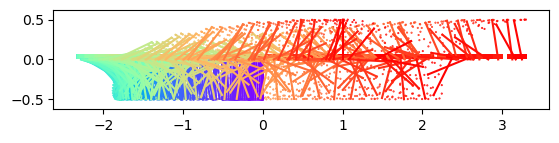

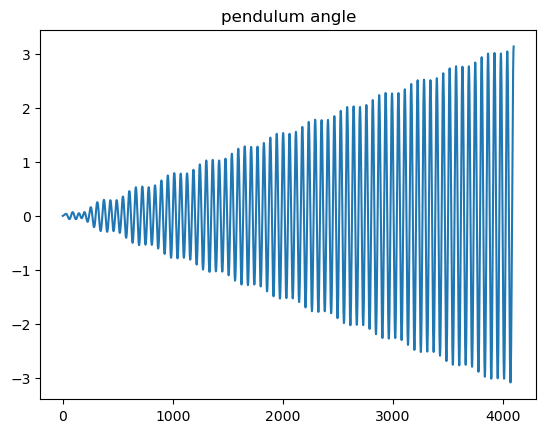

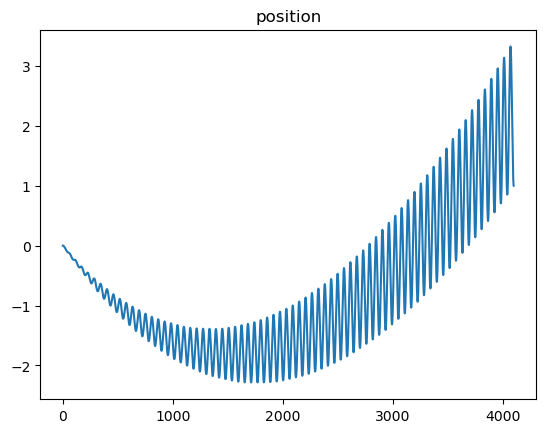

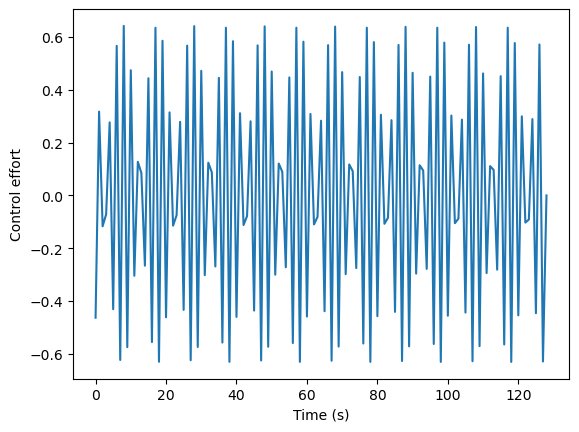

128
128
128
128
C shape:  (258, 645)
Fs[0]: [[  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]
 [  0.          32.66666667   0.           0.        ]
 [  0.         -84.93333333   0.          -0.        ]]
bs[0]: [ 0.          0.          3.33333333 -3.33333333]
f_0s[0]: [0. 0. 0. 0.]
relin step: 1
ifsnm num iters: 0 residual norm: 313.5240239761554 line search param: 0.9
ifsnm num iters: 1 residual norm: 31.35240930591933 line search param: 0.38742048900000015
ifsnm num iters: 2 residual norm: 19.205996329630278 line search param: 0.04710128697246249
ifsnm num iters: 3 residual norm: 18.323625357459118 line search param: 0.025031555049932444
ifsnm num iters: 4 residual norm: 18.006698636356287 line search param: 0.07178979876918531
ifsnm num iters: 5 residual norm: 17.305426202447975 line search param: 0.16677181699666577
ifsnm num iters: 6 residual norm: 15.5950700923652 line search param: 0.43046721000000016
ifsnm num iters:

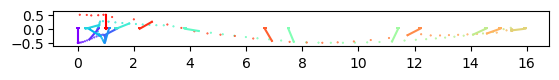

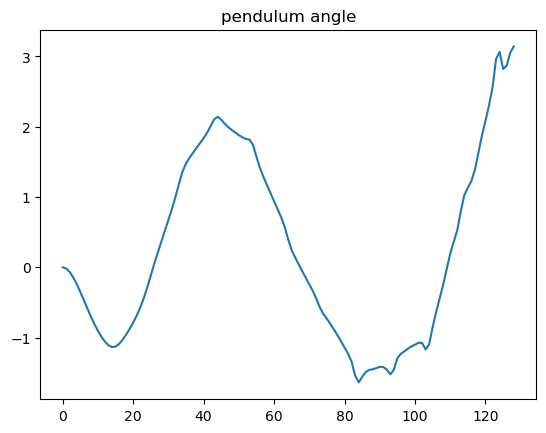

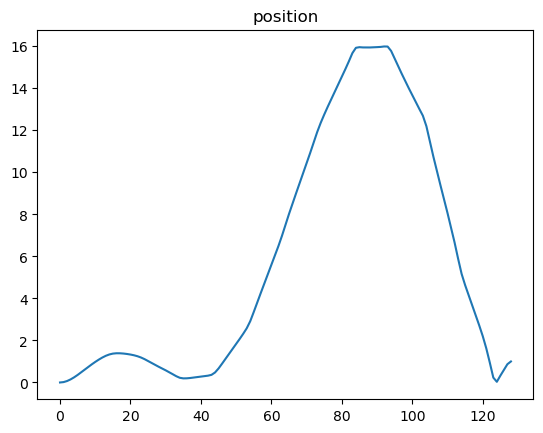

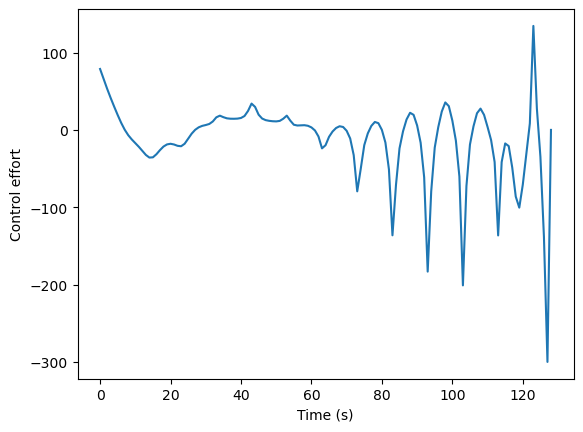

128
128
128
128
C shape:  (258, 645)
Fs[0]: [[  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]
 [  0.          32.66666667   0.           0.        ]
 [  0.         -84.93333333   0.          -0.        ]]
bs[0]: [ 0.          0.          3.33333333 -3.33333333]
f_0s[0]: [0. 0. 0. 0.]
relin step: 2
ifsnm num iters: 0 residual norm: 3605032441.26308 line search param: 1.0
ifsnm num iters: 1 residual norm: 1802478361.8354435 line search param: 0.9
ifsnm num iters: 2 residual norm: 948877632.1880975 line search param: 0.9
ifsnm num iters: 3 residual norm: 499494492.61165 line search param: 0.9
ifsnm num iters: 4 residual norm: 262884115.61833525 line search param: 0.9
ifsnm num iters: 5 residual norm: 138368901.1357368 line search param: 0.9
ifsnm num iters: 6 residual norm: 72827680.61798272 line search param: 0.9
ifsnm num iters: 7 residual norm: 38330826.577574015 line search param: 0.9
ifsnm num iters: 8 residual norm: 2017434

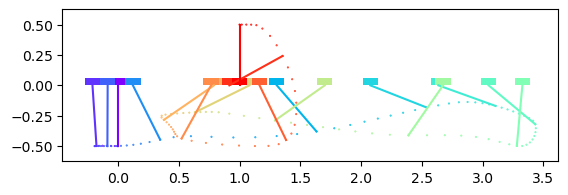

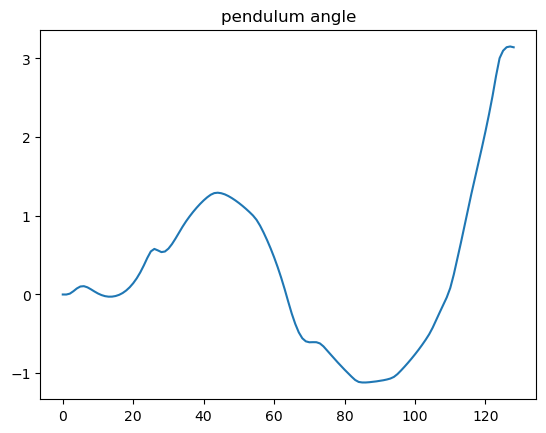

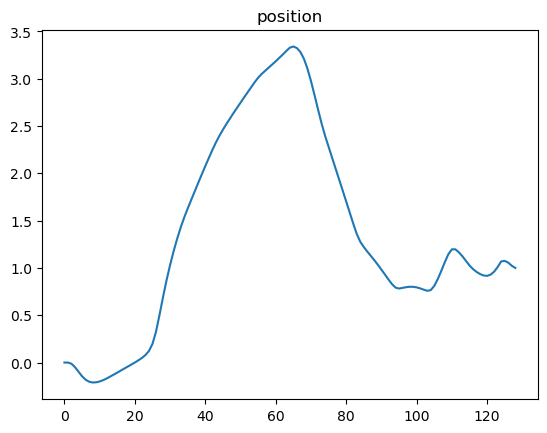

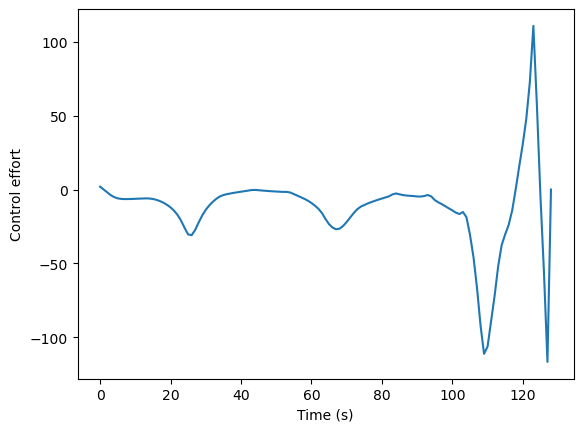

128
128
128
128
C shape:  (258, 645)
Fs[0]: [[  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]
 [  0.          32.66666667   0.           0.        ]
 [  0.         -84.93333333   0.          -0.        ]]
bs[0]: [ 0.          0.          3.33333333 -3.33333333]
f_0s[0]: [0. 0. 0. 0.]
relin step: 3
ifsnm num iters: 0 residual norm: 226516.0430058229 line search param: 1.0
ifsnm num iters: 1 residual norm: 7.519119616431585e-05 line search param: 1.0
ifsnm num iters: 2 residual norm: 1.4600352234785222e-11 line search param: 0.10941898913151243
feasible newton
num iters:  0
equality constraints norm 1.8933826949964067e-14


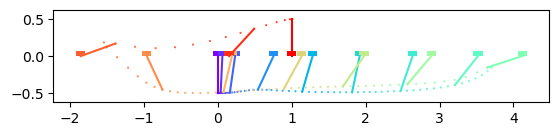

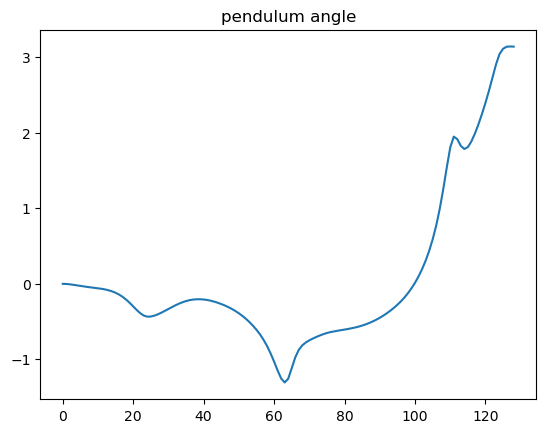

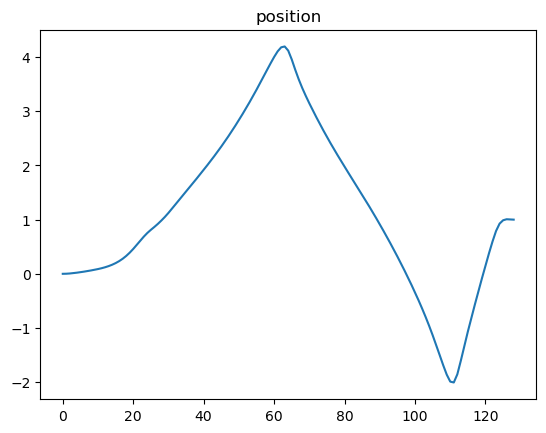

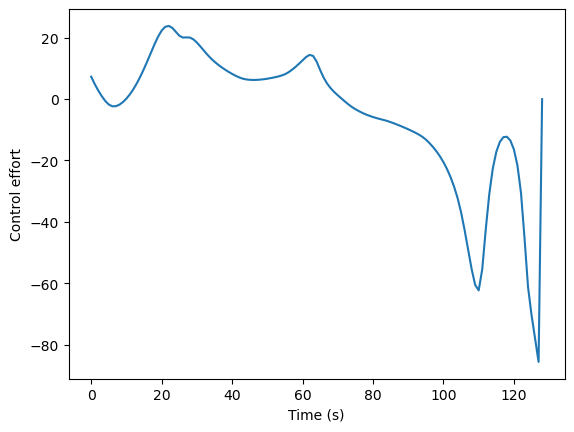

128
128
128
128
C shape:  (258, 645)
Fs[0]: [[  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]
 [  0.          32.66666667   0.           0.        ]
 [  0.         -84.93333333   0.          -0.        ]]
bs[0]: [ 0.          0.          3.33333333 -3.33333333]
f_0s[0]: [0. 0. 0. 0.]
relin step: 4
ifsnm num iters: 0 residual norm: 28116.78898475274 line search param: 1.0
ifsnm num iters: 1 residual norm: 1.0019942706782941e-05 line search param: 1.0
ifsnm num iters: 2 residual norm: 1.014285920849459e-11 line search param: 0.9
feasible newton
num iters:  0
equality constraints norm 1.0882950321049796e-14


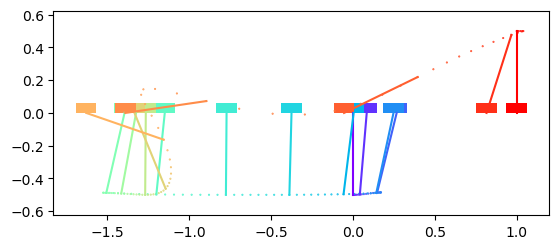

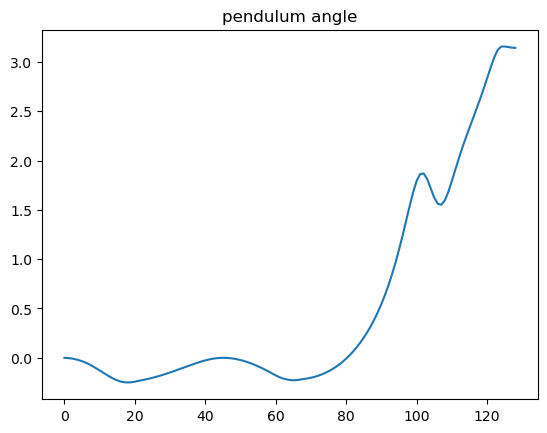

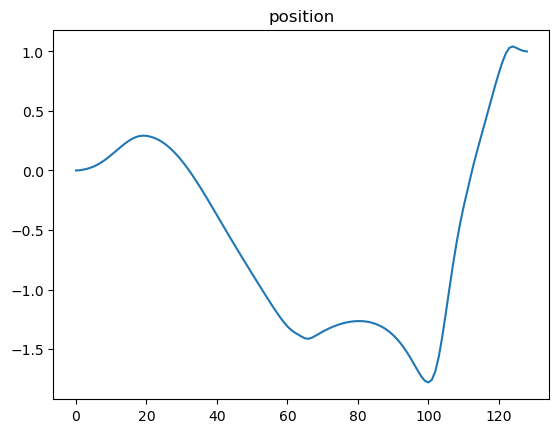

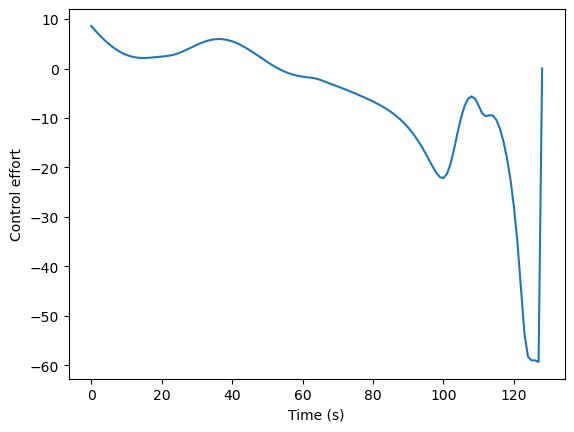

128
128
128
128
C shape:  (258, 645)
Fs[0]: [[  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]
 [  0.          32.66666667   0.           0.        ]
 [  0.         -84.93333333   0.          -0.        ]]
bs[0]: [ 0.          0.          3.33333333 -3.33333333]
f_0s[0]: [0. 0. 0. 0.]
relin step: 5
ifsnm num iters: 0 residual norm: 15311.13814136568 line search param: 1.0
ifsnm num iters: 1 residual norm: 1.4486272040704386e-06 line search param: 1.0
ifsnm num iters: 2 residual norm: 7.239196387061532e-12 line search param: 0.38742048900000015
feasible newton
num iters:  0
equality constraints norm 9.782734414776938e-15


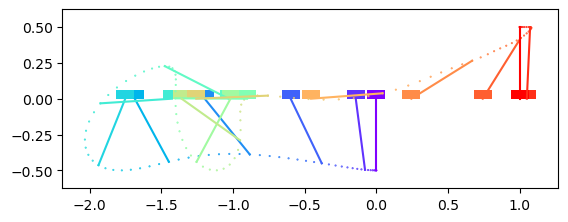

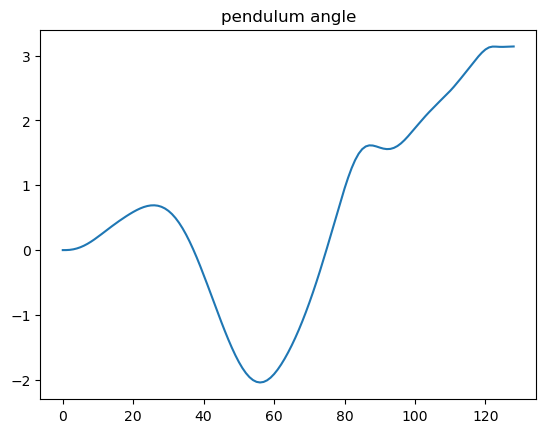

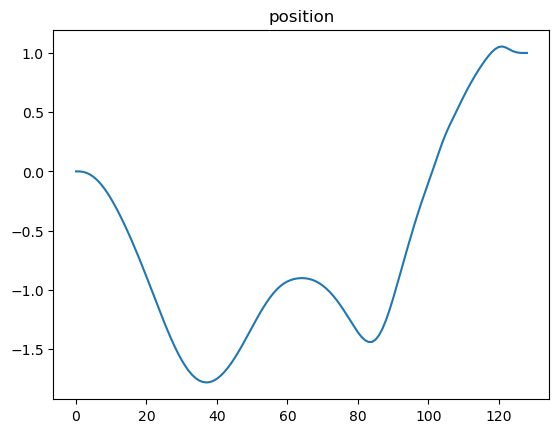

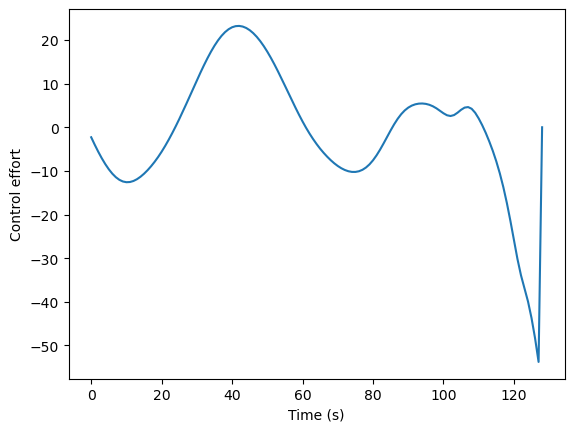

128
128
128
128
C shape:  (258, 645)
Fs[0]: [[  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]
 [  0.          32.66666667   0.           0.        ]
 [  0.         -84.93333333   0.          -0.        ]]
bs[0]: [ 0.          0.          3.33333333 -3.33333333]
f_0s[0]: [0. 0. 0. 0.]
relin step: 6
ifsnm num iters: 0 residual norm: 10228.833172096041 line search param: 1.0
ifsnm num iters: 1 residual norm: 9.349946464685711e-07 line search param: 1.0
ifsnm num iters: 2 residual norm: 4.884163306575772e-12 line search param: 0.6561000000000001
feasible newton
num iters:  0
equality constraints norm 9.613059975992647e-15


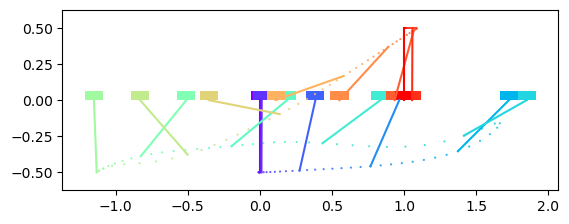

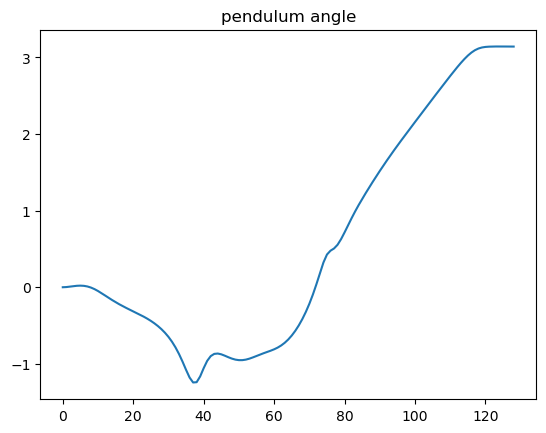

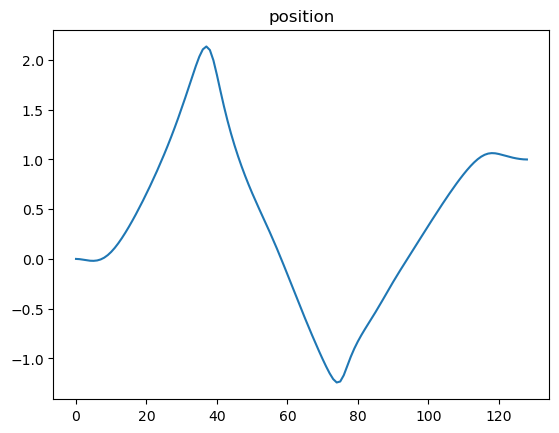

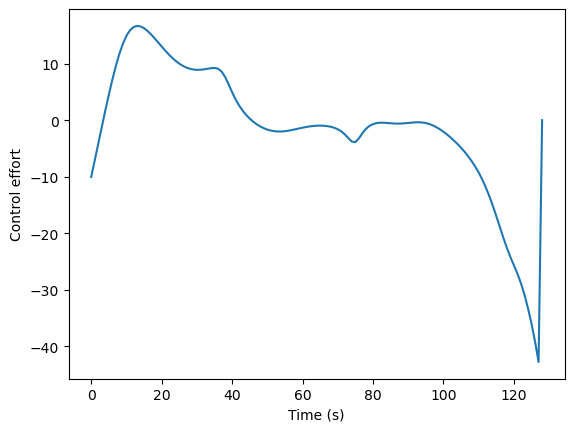

128
128
128
128
C shape:  (258, 645)
Fs[0]: [[  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]
 [  0.          32.66666667   0.           0.        ]
 [  0.         -84.93333333   0.          -0.        ]]
bs[0]: [ 0.          0.          3.33333333 -3.33333333]
f_0s[0]: [0. 0. 0. 0.]
relin step: 7
ifsnm num iters: 0 residual norm: 4795.821603240401 line search param: 1.0
ifsnm num iters: 1 residual norm: 6.649919656810918e-07 line search param: 1.0
ifsnm num iters: 2 residual norm: 7.958819635575021e-12 line search param: 0.81
feasible newton
num iters:  0
equality constraints norm 4.664128442267737e-15


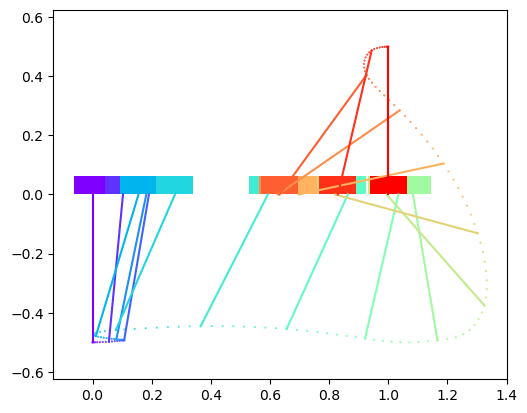

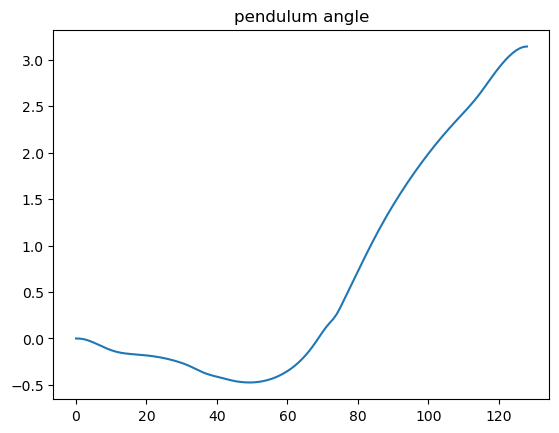

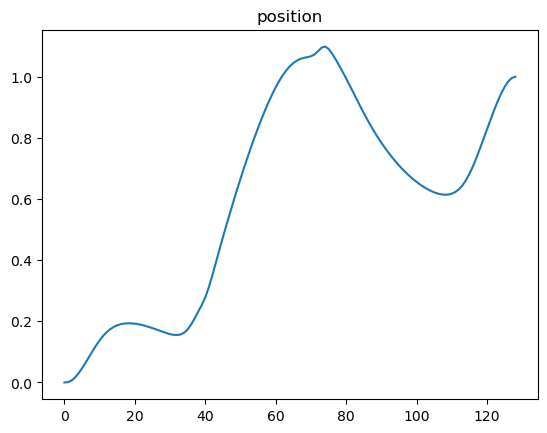

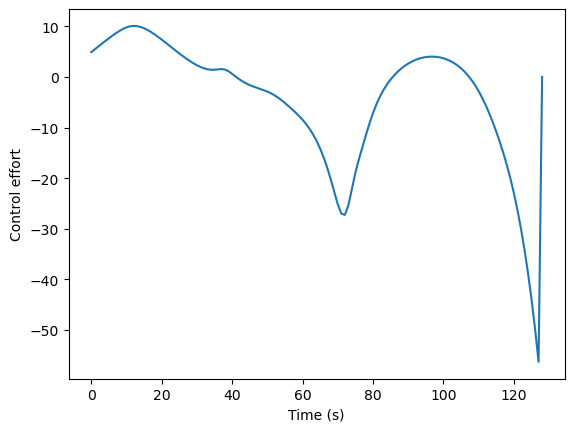

128
128
128
128
C shape:  (258, 645)
Fs[0]: [[  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]
 [  0.          32.66666667   0.           0.        ]
 [  0.         -84.93333333   0.          -0.        ]]
bs[0]: [ 0.          0.          3.33333333 -3.33333333]
f_0s[0]: [0. 0. 0. 0.]
relin step: 8
ifsnm num iters: 0 residual norm: 6310.295815063229 line search param: 1.0
ifsnm num iters: 1 residual norm: 3.8090386890016084e-07 line search param: 1.0
ifsnm num iters: 2 residual norm: 1.1203067346300739e-11 line search param: 0.43046721000000016
feasible newton
num iters:  0
equality constraints norm 6.23241255249586e-15


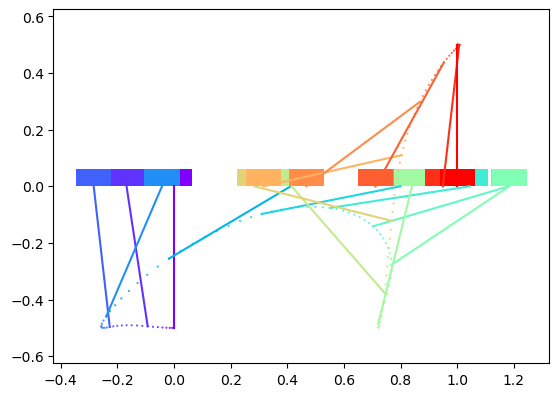

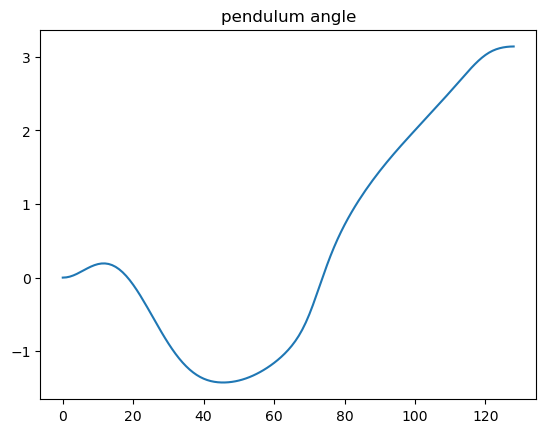

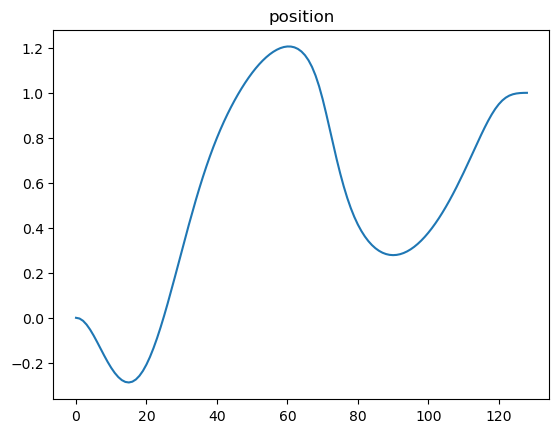

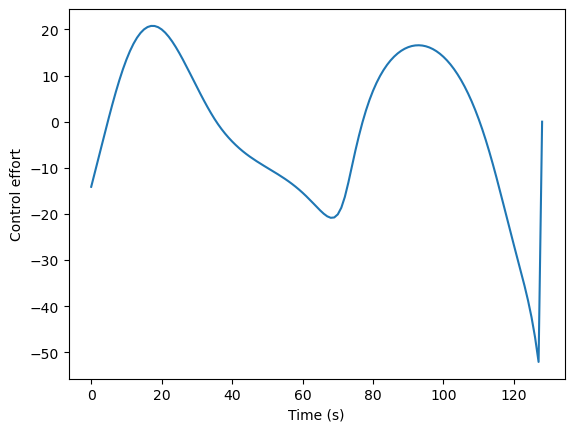

128
128
128
128
C shape:  (258, 645)
Fs[0]: [[  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]
 [  0.          32.66666667   0.           0.        ]
 [  0.         -84.93333333   0.          -0.        ]]
bs[0]: [ 0.          0.          3.33333333 -3.33333333]
f_0s[0]: [0. 0. 0. 0.]
relin step: 9
ifsnm num iters: 0 residual norm: 11688.547041973769 line search param: 1.0
ifsnm num iters: 1 residual norm: 9.466540663169441e-07 line search param: 1.0
ifsnm num iters: 2 residual norm: 1.3996150801945984e-11 line search param: 0.5314410000000002
feasible newton
num iters:  0
equality constraints norm 7.193662150762343e-15


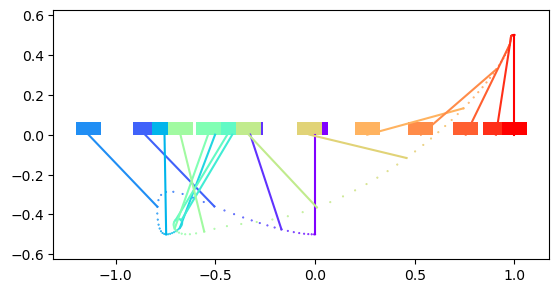

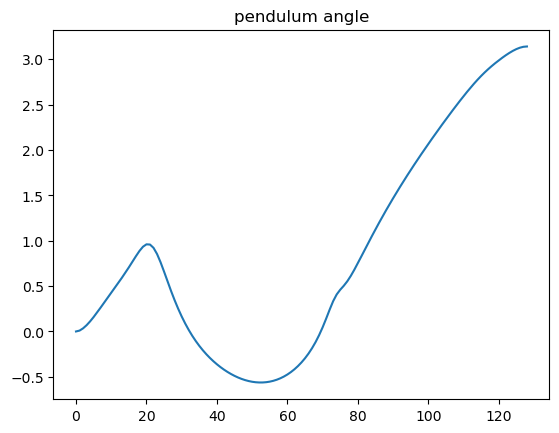

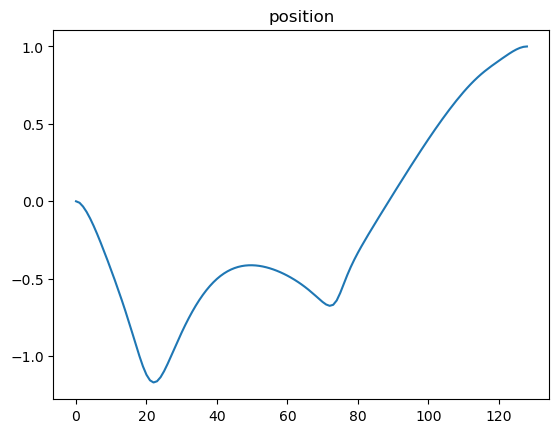

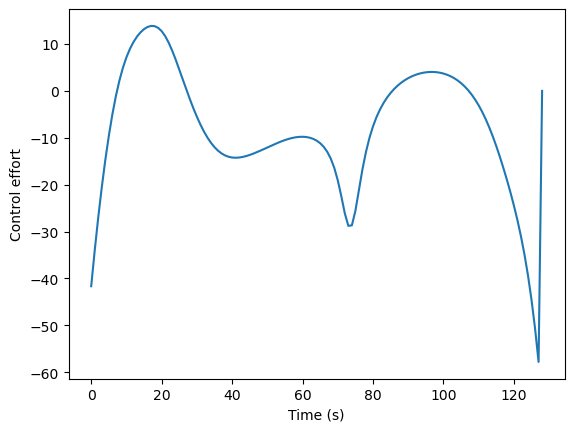

128
128
128
128
C shape:  (258, 645)
Fs[0]: [[  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]
 [  0.          32.66666667   0.           0.        ]
 [  0.         -84.93333333   0.          -0.        ]]
bs[0]: [ 0.          0.          3.33333333 -3.33333333]
f_0s[0]: [0. 0. 0. 0.]


True

In [52]:
better_cartpole_trajectory_optimizer(N, T, control_weighting, u_min, u_max, z_0, z_final, m_pend, m_cart, l_pend, filename="ohyeah")

In [53]:
def find_feasible_times():
    # Number of timesteps
    N = 64
    # Total amount of time
    T = 1.5
    
    control_weighting = np.ones(N + 1)
    
    u_min = -30.0
    u_max = 30.0
    
    z_0 = np.array([0.0, 0.0, 0.0, 0.0])
    z_final = np.array([2.0, np.pi, 0.0, 0.0])
    
    m_pend = 0.3
    m_cart = 0.3
    l_pend = 0.5

    good_ts = []
    
    for i in range(30):
        print("-----------Time",T,"--------------")
        good = cartpole_trajectory_optimizer(N, T, control_weighting, u_min, u_max, z_0, z_final, m_pend, m_cart, l_pend, plot_stuff=True)
        if good:
            good_ts.append(T)
            T -= 0.01
        else:
            print("---------bad time--------------")
            break
    
    print("Good times for swing-up:", good_ts)
        

In [54]:
#find_feasible_times()